# Devoir 1
    Frederick Auger-Morin
    Mohamed Chibane

## 3 Partie pratique : estimation de densité

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import utilitaires

In [54]:
data = np.loadtxt("iris.txt")

In [55]:
# 3.1 Implémentez un estimateur de densité paramétrique Gaussien diagonal.
# En se basant sur ce qui a été vu durant le labo:

class gauss_mv:
    def __init__(self,n_dims,cov_type="diagonale"):
        self.n_dims = n_dims
        self.mu = np.zeros((1,n_dims))
        self.cov_type = cov_type
        if cov_type =="isotropique":
            self.sigma_sq = 1.0
        elif cov_type=="diagonale":
            self.sigma_sq = np.ones(n_dims)
        elif cov_type=="full":
            self.sigma_sq = np.ones((n_dims,n_dims))
            
    def train(self, train_data):
        self.mu = np.mean(train_data, axis = 0)
        if self.cov_type == "isotropique":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0) / (self.n_dims * train_data.shape[0])
        elif self.cov_type == "diagonale":
            self.sigma_sq = np.sum((train_data - self.mu)**2.0,axis=0) / train_data.shape[0]
        elif self.cov_type == "full":
            self.sigma_sq = np.cov(np.transpose(train_data))
            
    def compute_predictions(self, test_data):

        if self.cov_type == "isotropique":
            # log(constante de normalisation)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - self.n_dims*np.log(self.sigma_sq)/2.0
            # il faut calculer la valeur de la log-probabilite de chaque exemple
            # de test sous le modele determine par mu et sigma_sq. le vecteur
            # des probabilites est/sera log_prob
            if self.n_dims > 1:
                log_prob = c - np.sum((test_data -  self.mu)**2.0,axis=1) / (2.0 * self.sigma_sq)
            else:
                log_prob = c - (test_data -  self.mu)**2.0 / (2.0 * self.sigma_sq)
                
        elif self.cov_type == "diagonale":
            # on prend le produit du vecteur représentant la diagonale (np.prod(self.sigma)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
            # on somme sur l'axe 1 après avoir divisé par sigma puisque celui ci aussi est
            # de dimension d
            log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)

            
        elif self.cov_type == "full":
            c = -self.n_dims * np.log(2.0*np.pi)/2.0
            det = np.linalg.det(self.cov)
            c += np.log(det)/2.0
            
            dmu = test_data-self.mu
            inv = np.linalg.inv(self.cov)
            
            dxs = np.dot(dmu,inv)
            dxsx = np.sum(dxs*dmu,axis=1)
            log_prob = c - dxsx
        return log_prob

In [56]:
# 3.2 Implémentez un estimateur de densité de Parzen à noyau Gaussien isotropique.
class parzen_gauss:
    def __init__(self,n_dims,sigma_sq=1.0,cov_type="isotropique"):
        self.n_dims = n_dims
        self.n=0
        self.cov_type = "isotropique"
        if cov_type =="isotropique":
            self.sigma_sq = sigma_sq
            
    def train(self, train_data):
        if self.cov_type =="isotropique":
            # On calcule d'abord la fonction de densité gaussienne isotropique centrée sur le point d'entrainement
            # Chaue gaussienne estimee de dimension n_dims est centree en mu qui sonty nos points dentrainement.
            self.mus = train_data
            self.n = train_data.shape[0]
            
    def compute_predictions(self, test_data):
        if self.cov_type == "isotropique": 
            # pour tous les points test, on doit calculer la densitee
            # la constante de normalization
            c = -np.log(((2*np.pi)**(self.n_dims/2.0))*(self.sigma_sq**(self.n_dims/2.0))*self.n)
            
            log_prob = np.zeros(test_data.shape[0]) 
            if self.n_dims > 1:
                i = 0
                # Pour chaque point de l'ensemble de test, on doit faire la somme de toutes les densites
                for point in test_data:
                    log_prob[i]= c + np.log(np.sum(np.exp(np.sum(np.power(point - self.mus,2),axis=1)/(-2.0*self.sigma_sq))))
                    i+=1
            else:
                i = 0
                # Pour chaque point de l'ensemble de test, on doit faire la somme de toutes les densites
                for point in test_data:
                    log_prob[i]= c + np.log(np.sum(np.exp(np.power(point-self.mus,2)/(-2*self.sigma_sq))))
                    i+=1
    
        return log_prob

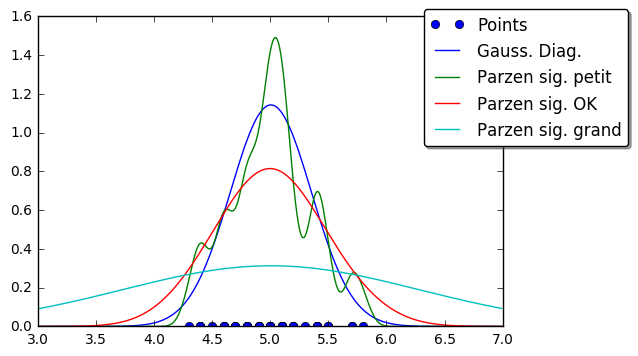

In [57]:
# 3.3 Densités 1D
d=1

partial_data = np.arange(3.0,7.0,.01) 
x = data[0:50,0] # on chosit la classe 1 et le premier feature

x=np.sort(x)

mdl_gauss = gauss_mv(d,cov_type="isotropique")

mdl_gauss.train(x)

densite_gauss = mdl_gauss.compute_predictions(partial_data)


mdl_parzen_small = parzen_gauss(d,.005)
mdl_parzen_small.train(x)
densite_parzen_small = mdl_parzen_small.compute_predictions(partial_data)

mdl_parzen_fine = parzen_gauss(d,0.117)
mdl_parzen_fine.train(x)
densite_parzen_fine = mdl_parzen_fine.compute_predictions(partial_data)

mdl_parzen_big = parzen_gauss(d,1.5)
mdl_parzen_big.train(x)
densite_parzen_big = mdl_parzen_big.compute_predictions(partial_data)


plt.plot(x,np.zeros(x.shape[0]),'ob')
plt.plot(partial_data,np.exp(densite_gauss))
plt.plot(partial_data,np.exp(densite_parzen_small))
plt.plot(partial_data,np.exp(densite_parzen_fine))
plt.plot(partial_data,np.exp(densite_parzen_big))

plt.legend(["Points","Gauss. Diag.","Parzen sig. petit","Parzen sig. OK","Parzen sig. grand"],
           loc='upper center', bbox_to_anchor=(1.05, 1.05), fancybox=True, shadow=True)
plt.show()



c:\Python27\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log


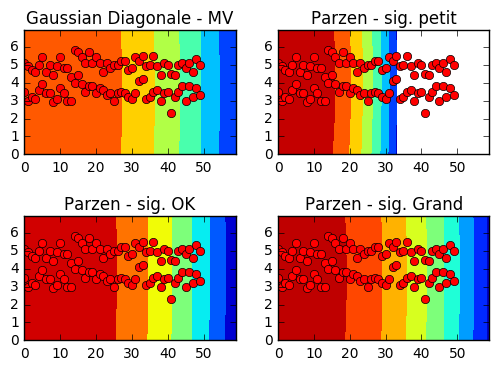

In [58]:
# 3.4
d=2
x= np.arange(0,60,1)
y=np.arange(0,7.0,0.1)
X,Y = np.meshgrid(x,y)

normal_std = np.mean(np.std(partial_data)**2)*2.0


partial_data = data[0:50,[0,1]] # on chosit la classe 1 et les deux premiers features


mdl_gauss = gauss_mv(d,cov_type="diagonale")
mdl_gauss.train(partial_data)

densite_gauss = np.zeros(X.shape)

for i in range(0,X.shape[1]):
        densite_gauss[:,i]= mdl_gauss.compute_predictions(np.column_stack((X[:,i],Y[:,i])))
        
mdl_parzen_small = parzen_gauss(d,normal_std/5.0)
mdl_parzen_small.train(partial_data)
densite_parzen_small = np.zeros(X.shape)
for i in range(0,X.shape[1]):
        densite_parzen_small[:,i]= mdl_parzen_small.compute_predictions(np.column_stack((X[:,i],Y[:,i])))


mdl_parzen_fine = parzen_gauss(d,normal_std)
mdl_parzen_fine.train(partial_data)
densite_parzen_fine = np.zeros(X.shape)
for i in range(0,X.shape[1]):
        densite_parzen_fine[:,i]= mdl_parzen_fine.compute_predictions(np.column_stack((X[:,i],Y[:,i])))

mdl_parzen_big = parzen_gauss(d,normal_std * 7.0)
mdl_parzen_big.train(partial_data)
densite_parzen_big = np.zeros(X.shape)
for i in range(0,X.shape[1]):
        densite_parzen_big[:,i]= mdl_parzen_big.compute_predictions(np.column_stack((X[:,i],Y[:,i])))


fig=plt.figure()
fig.subplots_adjust(hspace=.5)
plt.subplot(221)
plt.plot(partial_data,'or')
plt.title("Gaussian Diagonale - MV")
plt.contourf(X,Y,densite_gauss)

plt.subplot(222)
plt.plot(partial_data,'or')
plt.title("Parzen - sig. petit")
plt.contourf(X,Y, densite_parzen_small)

plt.subplot(223)
plt.plot(partial_data,'or')
plt.title("Parzen - sig. OK")
plt.contourf(X,Y, densite_parzen_fine)

plt.subplot(224)
plt.plot(partial_data,'or')
plt.title("Parzen - sig. Grand")
plt.contourf(X,Y, densite_parzen_big)
plt.show()

## 4 Partie pratique : classifieur de Bayes

In [59]:
# 4.1 : On melange les exemples d'iris
np.random.seed(123)
np.random.shuffle(data)
train = data[0:100] #100/150 pour le training
valid = data[100:] #50/150 pour la valid

part_train = train[:,[0,1,-1]] #on conserve seulement les deux premieres dimension et le label
part_valid = valid[:,[0,1,-1]]

In [60]:
# 4.2 : Classifieur de Bayes basé sur des densités paramétriques Gaussiennes diagonales 
class classif_bayes:

    def __init__(self,modeles_mv, priors):
        self.modeles_mv = modeles_mv
        self.priors = priors
        if len(self.modeles_mv) != len(self.priors):
            print 'Le nombre de modeles MV doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_mv)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle MV. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_mv[i].compute_predictions(test_data) +  np.log(self.priors[i])

        return log_pred

Taux d'erreur sur l'ensemble d'entrainement: 19.00%
Taux d'erreur sur l'ensemble de validation: 22.00%


c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x08090B90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x080904B0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07FD4590>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


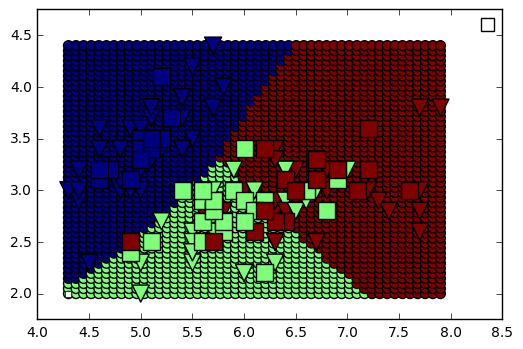

In [61]:
# 4.2 b) On entraine sur les 2 premiers traits caracteristiques et on visualise
d = 2
model_class1 = gauss_mv(d)
model_class2 = gauss_mv(d)
model_class3 = gauss_mv(d)

pt_class1 =[] #pt for part_train
pt_class2 =[]
pt_class3 =[]
for ex in part_train:
    if ex[-1] == 1:
        pt_class1.append(ex)
    elif ex[-1] == 2:
        pt_class2.append(ex)
    elif ex[-1] == 3:
        pt_class3.append(ex)
        
pt_class1 = np.asarray(pt_class1)
pt_class2 = np.asarray(pt_class2)
pt_class3 = np.asarray(pt_class3)

#on entraine le MV sur la partition des donnees de training

model_class1.train(pt_class1[:,:-1])
model_class2.train(pt_class2[:,:-1])
model_class3.train(pt_class3[:,:-1])

models = [model_class1,model_class2,model_class3]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(part_train))
priors = [float(len(pt_class1))/totEx,float(len(pt_class2))/totEx,float(len(pt_class3))/totEx]

classifier_1 = classif_bayes(models,priors)
log_prob_train = classifier_1.compute_predictions(part_train[:,:-1])

log_prob_valid = classifier_1.compute_predictions(part_valid[:,:-1])

classesPred_train = log_prob_train.argmax(axis=1)+1
classesPred_valid = log_prob_valid.argmax(axis=1)+1

print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid==part_valid[:,-1]).mean())*100.0)

utilitaires.gridplot(classifier_1,part_train,part_valid)

In [62]:
# 4.2 d) On entraine de la meme facon mais en utilisant tous les features (d = 4) au lieu des deux premiers

d = 4
model_class1 = gauss_mv(d)
model_class2 = gauss_mv(d)
model_class3 = gauss_mv(d)

class1 =[] #pt for part_train
class2 =[]
class3 =[]
for ex in train:
    if ex[-1] == 1:
        class1.append(ex)
    elif ex[-1] == 2:
        class2.append(ex)
    elif ex[-1] == 3:
        class3.append(ex)
        
class1 = np.asarray(class1)
class2 = np.asarray(class2)
class3 = np.asarray(class3)

#on entraine le MV sur la partition des donnees de training

model_class1.train(class1[:,:-1])
model_class2.train(class2[:,:-1])
model_class3.train(class3[:,:-1])

models = [model_class1,model_class2,model_class3]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(train))
priors = [float(len(class1))/totEx,float(len(class2))/totEx,float(len(class3))/totEx]

classifier_1 = classif_bayes(models,priors)
log_prob_train = classifier_1.compute_predictions(train[:,:-1])
log_prob_valid = classifier_1.compute_predictions(valid[:,:-1])

classesPred_train = log_prob_train.argmax(axis=1)+1
classesPred_valid = log_prob_valid.argmax(axis=1)+1

print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train==train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid==valid[:,-1]).mean())*100.0)

Taux d'erreur sur l'ensemble d'entrainement: 4.00%
Taux d'erreur sur l'ensemble de validation: 4.00%


In [63]:
#4.3 Classifieur de Bayes basé sur des densités de Parzen avec noyau Gaussien isotropique
class classif_bayes_parzen:
    def __init__(self,modeles_parzen, priors):
        self.modeles_parzen = modeles_parzen
        self.priors = priors
        if len(self.modeles_parzen) != len(self.priors):
            print 'Le nombre de modeles de fenetres de Parzen doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_parzen)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle avec fenetres de Parzen. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_parzen[i].compute_predictions(test_data) +  np.log(self.priors[i])

        return log_pred

Pour sigma = 0.0100
Taux d'erreur sur l'ensemble d'entrainement: 8.00%
Taux d'erreur sur l'ensemble de validation: 30.00%
Pour sigma = 0.2000
Taux d'erreur sur l'ensemble d'entrainement: 21.00%
Taux d'erreur sur l'ensemble de validation: 22.00%
Pour sigma = 1.5000
Taux d'erreur sur l'ensemble d'entrainement: 28.00%
Taux d'erreur sur l'ensemble de validation: 46.00%


c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07C22A70>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07C22990>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07C220B0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


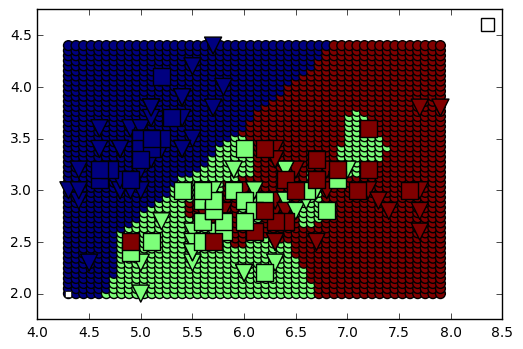

c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07FE0730>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x08189250>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x07669DF0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


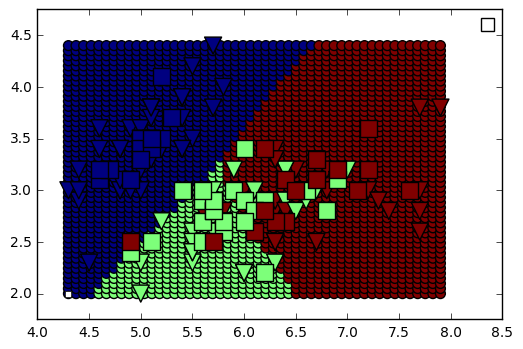

c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0538E2F0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x08489C70>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
c:\Python27\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0538EF90>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


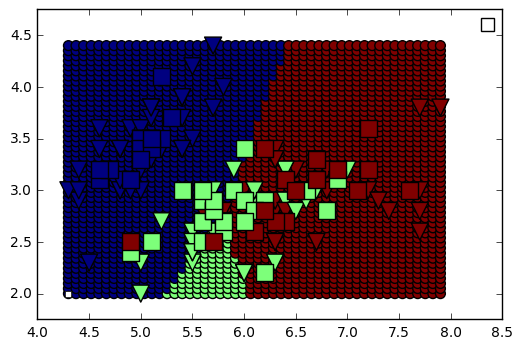

In [64]:
# 4.3 b) On entraine sur les 2 premiers traits caracteristiques et on visualise
d = 2
small_sig = .01
normal_sig = 0.2
big_sig = 1.5
#modele avec sigma petit
model_class11 = parzen_gauss(d,small_sig)
model_class12 = parzen_gauss(d,small_sig)
model_class13 = parzen_gauss(d,small_sig)
#modele avec sigma de dimension raisonnable
model_class21 = parzen_gauss(d,normal_sig)
model_class22 = parzen_gauss(d,normal_sig)
model_class23 = parzen_gauss(d,normal_sig)
#modele avec sigma trop grand
model_class31 = parzen_gauss(d,big_sig)
model_class32 = parzen_gauss(d,big_sig)
model_class33 = parzen_gauss(d,big_sig)

#Regroupe l'ensemble d'entrainement melange en classes identiques
pt_class1 =[] #pt for part_train
pt_class2 =[]
pt_class3 =[]
for ex in part_train:
    if ex[-1] == 1:
        pt_class1.append(ex)
    elif ex[-1] == 2:
        pt_class2.append(ex)
    elif ex[-1] == 3:
        pt_class3.append(ex)
        
pt_class1 = np.asarray(pt_class1)
pt_class2 = np.asarray(pt_class2)
pt_class3 = np.asarray(pt_class3)

#on entraine les fenetres de Parzen sur la partition des donnees de training
#modele avec petit sigma
model_class11.train(pt_class1[:,:-1])
model_class12.train(pt_class2[:,:-1])
model_class13.train(pt_class3[:,:-1])
#modele avec sigma de bonne dimension
model_class21.train(pt_class1[:,:-1])
model_class22.train(pt_class2[:,:-1])
model_class23.train(pt_class3[:,:-1])
#modele avec trop grand sigma
model_class31.train(pt_class1[:,:-1])
model_class32.train(pt_class2[:,:-1])
model_class33.train(pt_class3[:,:-1])


models_small = [model_class11,model_class12,model_class13]
models_normal= [model_class21,model_class22,model_class23]
models_big =   [model_class31,model_class32,model_class33]

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(part_train))
priors = [float(len(pt_class1))/totEx,float(len(pt_class2))/totEx,float(len(pt_class3))/totEx]

#Pour sigma trop petit
classifier_small = classif_bayes_parzen(models_small,priors)
log_prob_train_small = classifier_small.compute_predictions(part_train[:,:-1])
log_prob_valid_small = classifier_small.compute_predictions(part_valid[:,:-1])

classesPred_train_small = log_prob_train_small.argmax(axis=1)+1
classesPred_valid_small = log_prob_valid_small.argmax(axis=1)+1

print "Pour sigma = %.4f" % small_sig
print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train_small==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid_small==part_valid[:,-1]).mean())*100.0)

#Pour sigma de bonne dimension
classifier_normal = classif_bayes_parzen(models_normal,priors)
log_prob_train_normal = classifier_normal.compute_predictions(part_train[:,:-1])
log_prob_valid_normal = classifier_normal.compute_predictions(part_valid[:,:-1])

classesPred_train_normal = log_prob_train_normal.argmax(axis=1)+1
classesPred_valid_normal = log_prob_valid_normal.argmax(axis=1)+1
print "Pour sigma = %.4f" % normal_sig
print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train_normal==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid_normal==part_valid[:,-1]).mean())*100.0)

#Pour sigma trop grand
classifier_big = classif_bayes_parzen(models_big,priors)
log_prob_train_big = classifier_big.compute_predictions(part_train[:,:-1])
log_prob_valid_big = classifier_big.compute_predictions(part_valid[:,:-1])

classesPred_train_big = log_prob_train_big.argmax(axis=1)+1
classesPred_valid_big = log_prob_valid_big.argmax(axis=1)+1
print "Pour sigma = %.4f" % big_sig
print "Taux d'erreur sur l'ensemble d'entrainement: %.2f%%" % ((1-(classesPred_train_big==part_train[:,-1]).mean())*100.0)
print "Taux d'erreur sur l'ensemble de validation: %.2f%%" % ((1-(classesPred_valid_big==part_valid[:,-1]).mean())*100.0)



utilitaires.gridplot(classifier_small,part_train,part_valid)

utilitaires.gridplot(classifier_normal,part_train,part_valid)

utilitaires.gridplot(classifier_big,part_train,part_valid)

In [65]:
def sigma_learning_curve(n_dims,class_data,train_data,valid_data,sigmas,priors):
    class1 = class_data[0]
    class2 = class_data[1]
    class3 = class_data[2]
    
    result = np.zeros((sigmas.shape[0],3))
    
    for i in range(0,len(sigmas)):
        sig = sigmas[i]
        model_class1 = parzen_gauss(d,sig)
        model_class2 = parzen_gauss(d,sig)
        model_class3 = parzen_gauss(d,sig)
        
        model_class1.train(class1)
        model_class2.train(class2)
        model_class3.train(class3)
        
        models = [model_class1,model_class2,model_class3]
       
        classifier = classif_bayes_parzen(models,priors)
        log_prob_train = classifier.compute_predictions(train_data[:,:-1])
        log_prob_valid = classifier.compute_predictions(valid_data[:,:-1])

        classesPred_train = log_prob_train.argmax(axis=1)+1
        err_train =  1.0-(classesPred_train==train_data[:,-1]).mean()
        
        classesPred_valid = log_prob_valid.argmax(axis=1)+1     
        err_valid = 1.0 - (classesPred_valid==valid_data[:,-1]).mean()
        
        result[i,:] = [sig,err_train,err_valid]
        
    return result

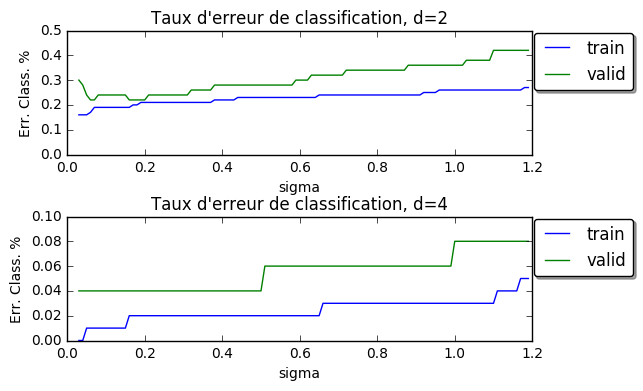

In [74]:
# 4.3 c)
sigmas = np.arange(0.03,1.2,0.01)

#Regroupe l'ensemble d'entrainement melange en classes identiques
pt_class1 =[] #pt for part_train
pt_class2 =[]
pt_class3 =[]
for ex in part_train:
    if ex[-1] == 1:
        pt_class1.append(ex)
    elif ex[-1] == 2:
        pt_class2.append(ex)
    elif ex[-1] == 3:
        pt_class3.append(ex)
        
pt_class1 = np.asarray(pt_class1)
pt_class2 = np.asarray(pt_class2)
pt_class3 = np.asarray(pt_class3)

test_data_2d = np.array([pt_class1[:,:-1],pt_class2[:,:-1],pt_class3[:,:-1]])



#Regroupe l'ensemble d'entrainement melange en classes identiques
class1 =[] #pt for part_train
class2 =[]
class3 =[]
for ex in train:
    if ex[-1] == 1:
        class1.append(ex)
    elif ex[-1] == 2:
        class2.append(ex)
    elif ex[-1] == 3:
        class3.append(ex)
        
class1 = np.asarray(class1)
class2 = np.asarray(class2)
class3 = np.asarray(class3)

test_data_4d = np.array([class1[:,:-1],class2[:,:-1],class3[:,:-1]])
valid_data_4d = valid

# Nos priors pour chaque classe seront simplement le nombre d'exemple de chaque test dans l'ensemble aleatoire de training
totEx = float(len(part_train))
priors = [float(len(pt_class1))/totEx,float(len(pt_class2))/totEx,float(len(pt_class3))/totEx]


learning_curve_2d = sigma_learning_curve(2,test_data_2d,part_train,part_valid,sigmas,priors)

learning_curve_4d = sigma_learning_curve(4,test_data_4d,train,valid,sigmas,priors)

fig = plt.figure()
fig.subplots_adjust(hspace=.5)
plt.subplot(211)
plt.plot(learning_curve_2d[:,0],learning_curve_2d[:,1],learning_curve_2d[:,0],learning_curve_2d[:,2])
plt.title("Taux d'erreur de classification, d=2")
plt.ylabel("Err. Class. %")
plt.xlabel("sigma")
plt.legend(["train","valid"],loc='upper center', bbox_to_anchor=(1.11, 1.05), fancybox=True, shadow=True)
plt.ylim(0,0.5)
plt.subplot(212)
plt.plot(learning_curve_4d[:,0],learning_curve_4d[:,1],learning_curve_4d[:,0],learning_curve_4d[:,2])
plt.title("Taux d'erreur de classification, d=4")
plt.ylabel("Err. Class. %")
plt.xlabel("sigma")
plt.legend(["train","valid"],loc='upper center', bbox_to_anchor=(1.11, 1.05), fancybox=True, shadow=True)
plt.ylim(0,0.1)
plt.show()

# 4.4 
Suite à nos expériences et en observant les résultats obtenus, il n<est pas clair qu'un des deux algorithme soit préférable à l'autre. En effet, on obtient des erreurs de classification semblables, voire même identiques peu importe si d = 2 ou 4. 

En effet, l'erreur de classification sur l'ensemble de validation pour le classifieur de Bayes avec fenêtres de parzen est de 22% quand d = 2 avec une valeur de l'hyper-paramètre sigma ~= 0.2 et de 4% quand d=4 avec une valeur de l'hyper-paramètre sigma ~= 0.2. 
On observe les mêmes résultats quand on utilise le classifieur de Bayes avec densités gaussiennes paramétriques. En effet, l'erreur de calssification sur l'ensemble de validation est de 22% quand d= 2 et de 4% quand d = 4.

Nous choisirons donc, puisque les résultats sont similaires, voire même identiques, l'algorithme d'estimation de densité le plus simple (plus partimonieux, plus faible capacité, moins de risques de sur-apprentissage), c'est-à-dire le classifieur de Bayes avec l'estimation de densité gaussienne paramétrique.  
